In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, chebwin
from scipy.interpolate import RegularGridInterpolator
from skimage.transform import resize
from skimage.transform import warp
from skimage import transform

fs = 1000;
rep_degree = 973
L = 1024
VT = 2.2

In [ ]:
def generate_lfm(duration = 10, snr = 0):
  frequency_band = [1,100]
  time_vector = np.linspace(0,duration,fs*duration+1,endpoint = False);
  lfm_signal = np.array(chirp(time_vector, f0=frequency_band[0], f1=frequency_band[1], t1=duration, method='linear'))
  lfm_signal0 = np.zeros(duration*fs);

  time = np.linspace(0,2*duration , 2*fs*duration+1,endpoint=False)

  snr_linear = 10**(snr/10.0);
  noise_power = np.var(lfm_signal)/snr_linear;
  print(type(noise_power),type(time))
  noise = np.random.normal(0,np.sqrt(noise_power),len(time));
  final_signal = np.concatenate((lfm_signal0,lfm_signal)) + noise

  return final_signal , time;

In [ ]:
def generate_cwfm(duration = 10, snr = 0):
  frequency_band = [40,100]
  time_vector = np.linspace(0,duration,(duration-4)*fs,endpoint = False);
  cwfm_signal = np.array(chirp(time_vector, f0=frequency_band[0], f1=frequency_band[1], t1=duration-4, method='linear'))

  frequency_band2 = [1,40]
  time_vector2 = np.linspace(0,4,fs*4,endpoint = False)
  cwfm_signal1 = np.array(chirp(time_vector2, f0=frequency_band2[0], f1=frequency_band2[1], t1=2, method='linear'))
  cwfm_signal0 = np.zeros(duration*fs);

  cwfm_signal = np.concatenate((cwfm_signal,cwfm_signal1));
  time = np.linspace(0,2*duration , 2*fs*duration,endpoint=False)


  snr_linear = 10**(snr/10.0);
  noise_power = np.var(cwfm_signal)/snr_linear;
  print(type(noise_power),type(time))
  noise = np.random.normal(0,np.sqrt(noise_power),len(time));
  final_signal = np.concatenate((cwfm_signal0,cwfm_signal)) + noise

  return final_signal , time;



In [ ]:

def generate_ptfm(duration=10, snr=0):
    frequency_band = [1, 100]
    fs = 1000  # Adjust the sampling frequency as needed
    time_vector = np.linspace(0,2, 1600 , endpoint=False)
    #make 10 chirps of length 1000 and then the
    signal = np.array([])
    for _ in range(5):
      ch = np.array(chirp(time_vector,f0=frequency_band[0],f1=frequency_band[1],t1 = 2,method="linear"))
      ch = np.concatenate((ch,np.zeros(400)))
      signal = np.concatenate((signal,ch));

    signal0 = np.zeros(duration*fs+1);
    time = np.linspace(0,20,2*fs*duration + 1,endpoint=False)
    snr = 10**(snr/10.0);
    noise_power = np.var(signal)/snr;
    noise = np.random.normal(0,np.sqrt(noise_power),len(time));
    final_signal = np.concatenate((signal0,signal)) + noise

    return final_signal , time


<class 'numpy.float64'> <class 'numpy.ndarray'>
<class 'numpy.float64'> <class 'numpy.ndarray'>


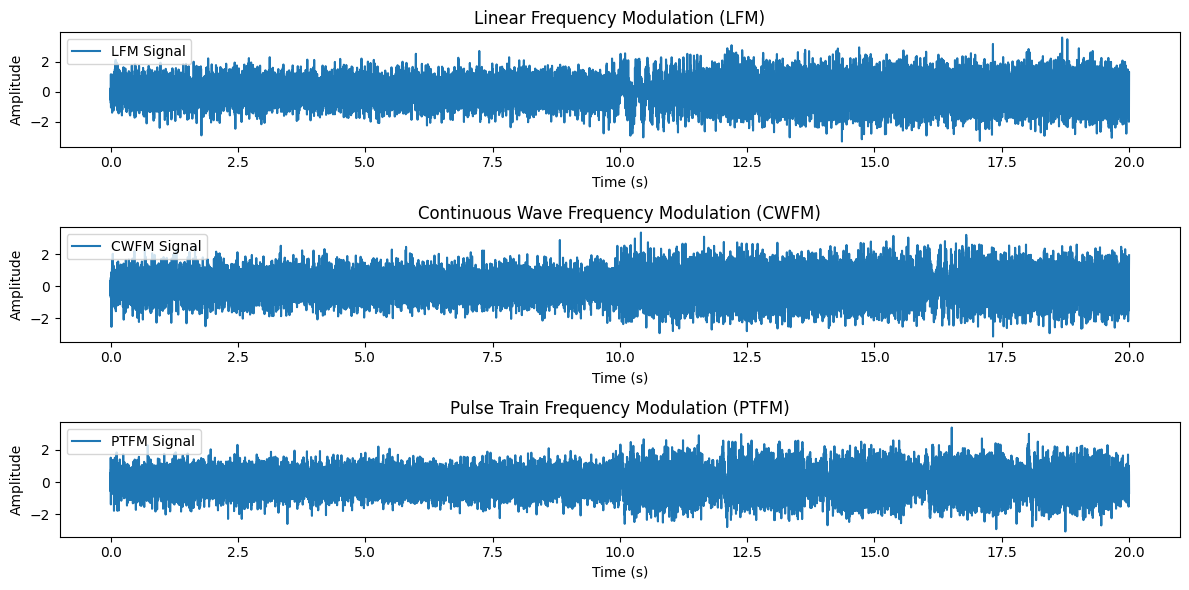

In [ ]:
lfm_signal  , time1 = generate_lfm(snr=0);
cwfm_signal , time2 = generate_cwfm(snr=0);
ptfm_signal , time3 = generate_ptfm(snr=0);

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(time1, lfm_signal, label='LFM Signal')
plt.title('Linear Frequency Modulation (LFM)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time2, cwfm_signal, label='CWFM Signal')
plt.title('Continuous Wave Frequency Modulation (CWFM)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time3, ptfm_signal, label='PTFM Signal')
plt.title('Pulse Train Frequency Modulation (PTFM)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def stft(signal, fs = 1000, window_size = 1024, rep_degree = 973):
    hop_size = window_size - rep_degree;
    num_samples = len(signal)
    num_segments = int(np.ceil((num_samples - window_size) / hop_size))
    #calculate the number of needed as per the window and hop size to cover the whole signal
    print(window_size,num_segments);
    stft_result = np.zeros((window_size, num_segments), dtype=np.complex128)

    for i in range(num_segments):
        start_index = i * hop_size
        end_index = start_index + window_size
        segment = signal[start_index:end_index]
        #iterating over each segment of the signal, computing FFT
        # Use Chebyshev window
        window = chebwin(window_size, at=60)#at=60 means side lob attenuation
        windowed_segment = segment * window

        fft_result = np.fft.fft(windowed_segment)

        stft_result[:, i] = fft_result

    t = np.arange(0, num_segments) * hop_size / fs
    f = np.fft.fftfreq(window_size, 1/fs)

    stft_result = 10*np.log10(np.abs(stft_result[:window_size//2,:]));
    f = f[:window_size//2]
    t = np.linspace(0,t[len(t)-1],window_size//2);


    stft_result = resize(stft_result,(len(f),len(f)),mode = 'constant', anti_aliasing=True)
    # print(fft_result)
    return t, f, stft_result


1024 177
1024 177


<ipython-input-6-ad3949994109>:15: DeprecationWarning: Importing chebwin from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.chebwin' or the convenience function 'scipy.signal.get_window' instead.
  window = chebwin(window_size, at=60)#at=60 means side lob attenuation


1024 177


<Figure size 500x1000 with 0 Axes>

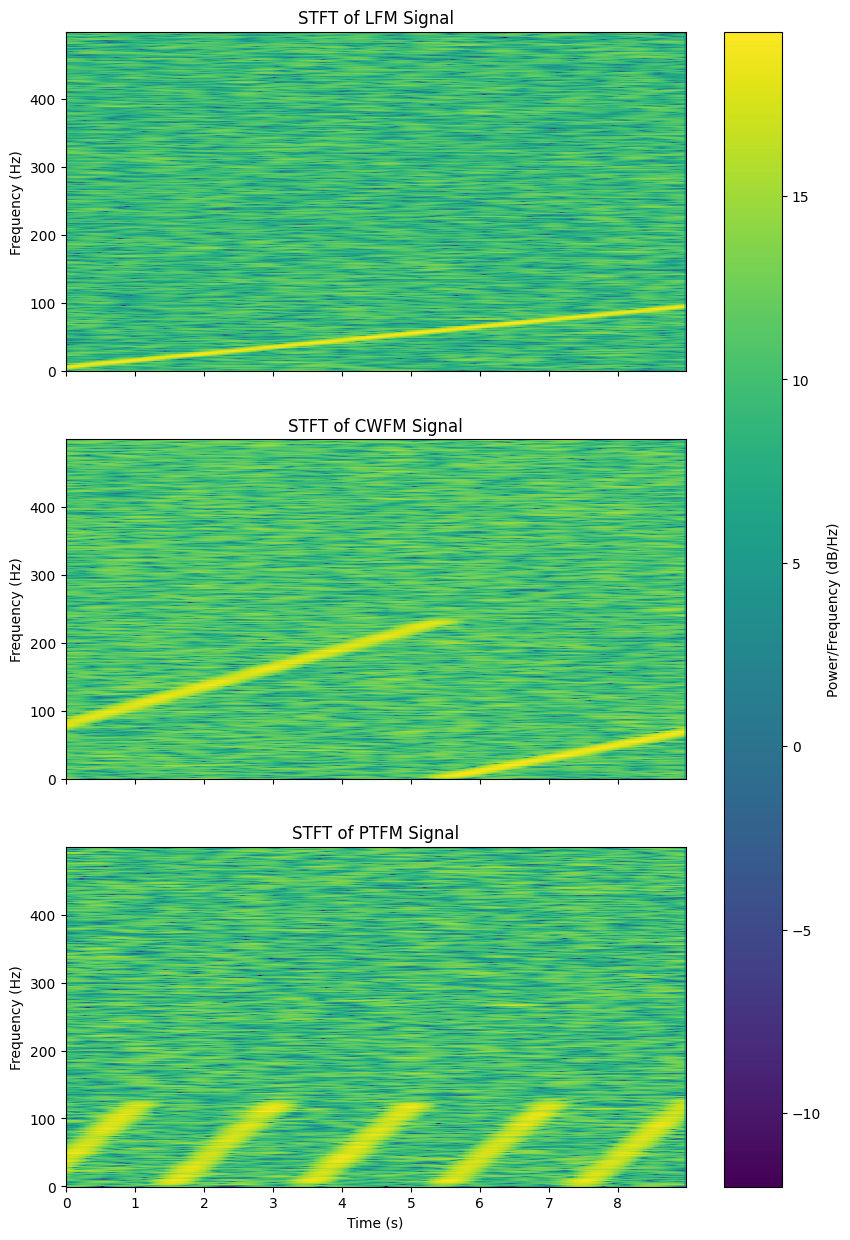

In [ ]:
t_lfm,f_lfm,Sxx_lfm    = stft(lfm_signal[((len(lfm_signal)-1)//2):],fs,L,rep_degree);
t_cwfm,f_cwfm,Sxx_cwfm = stft(cwfm_signal[((len(cwfm_signal)-1)//2):],fs,L,rep_degree);
t_ptfm,f_ptfm,Sxx_ptfm = stft(ptfm_signal[((len(ptfm_signal)-1)//2):],fs,L,rep_degree);
plt.figure(figsize=(5, 10))

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

axes[0].pcolormesh(t_lfm, f_lfm,Sxx_lfm, shading='auto')
axes[0].set_title('STFT of LFM Signal')
axes[0].set_ylabel('Frequency (Hz)')

axes[1].pcolormesh(t_cwfm, f_cwfm,Sxx_cwfm, shading='auto')
axes[1].set_title('STFT of CWFM Signal')
axes[1].set_ylabel('Frequency (Hz)')

im = axes[2].pcolormesh(t_ptfm,f_ptfm, Sxx_ptfm, shading='auto')
axes[2].set_title('STFT of PTFM Signal')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')

# Add colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('Power/Frequency (dB/Hz)')

plt.show()

In [ ]:
def radon2(image,circle=True, Normal = False):
  theta = np.linspace(0., 180., max(image.shape), endpoint=True)
  if circle:
      shape_min = min(image.shape)
      radius = shape_min // 2
      img_shape = np.array(image.shape)
      coords = np.array(np.ogrid[: image.shape[0], : image.shape[1]], dtype=object)
      dist = ((coords - img_shape // 2) ** 2).sum(0)
      outside_reconstruction_circle = dist > radius**2
      slices = tuple(
          slice(int(np.ceil(excess / 2)), int(np.ceil(excess / 2) + shape_min))
          if excess > 0
          else slice(None)
          for excess in (img_shape - shape_min)
      )
      padded_image = image[slices]
  else:
    diagonal = np.sqrt(2) * max(image.shape)
    pad = [int(np.ceil(diagonal - s)) for s in image.shape]
    new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
    old_center = [s // 2 for s in image.shape]
    pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
    pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

  # padded_image is always square
  if padded_image.shape[0] != padded_image.shape[1]:
    raise ValueError('padded_image must be a square')
  center = padded_image.shape[0] // 2
  radon_image = np.zeros((padded_image.shape[0], len(theta)), dtype=image.dtype)

  for i, angle in enumerate(np.deg2rad(theta)):
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    R = np.array(
        [
            [cos_a, sin_a, -center * (cos_a + sin_a - 1)],
            [-sin_a, cos_a, -center * (cos_a - sin_a - 1)],
            [0, 0, 1],
        ]
    )
    rotated = warp(padded_image, R, clip=False)
    radon_image[:, i] = rotated.sum(0)

    # Normalize each row in the Radon transform separately
    if Normal:
      normalization_factor = np.maximum(np.sum(radon_image != 0, axis=1), 1)
      radon_image_normalized = radon_image / normalization_factor[:, np.newaxis]

  return theta, radon_image


<Figure size 500x1000 with 0 Axes>

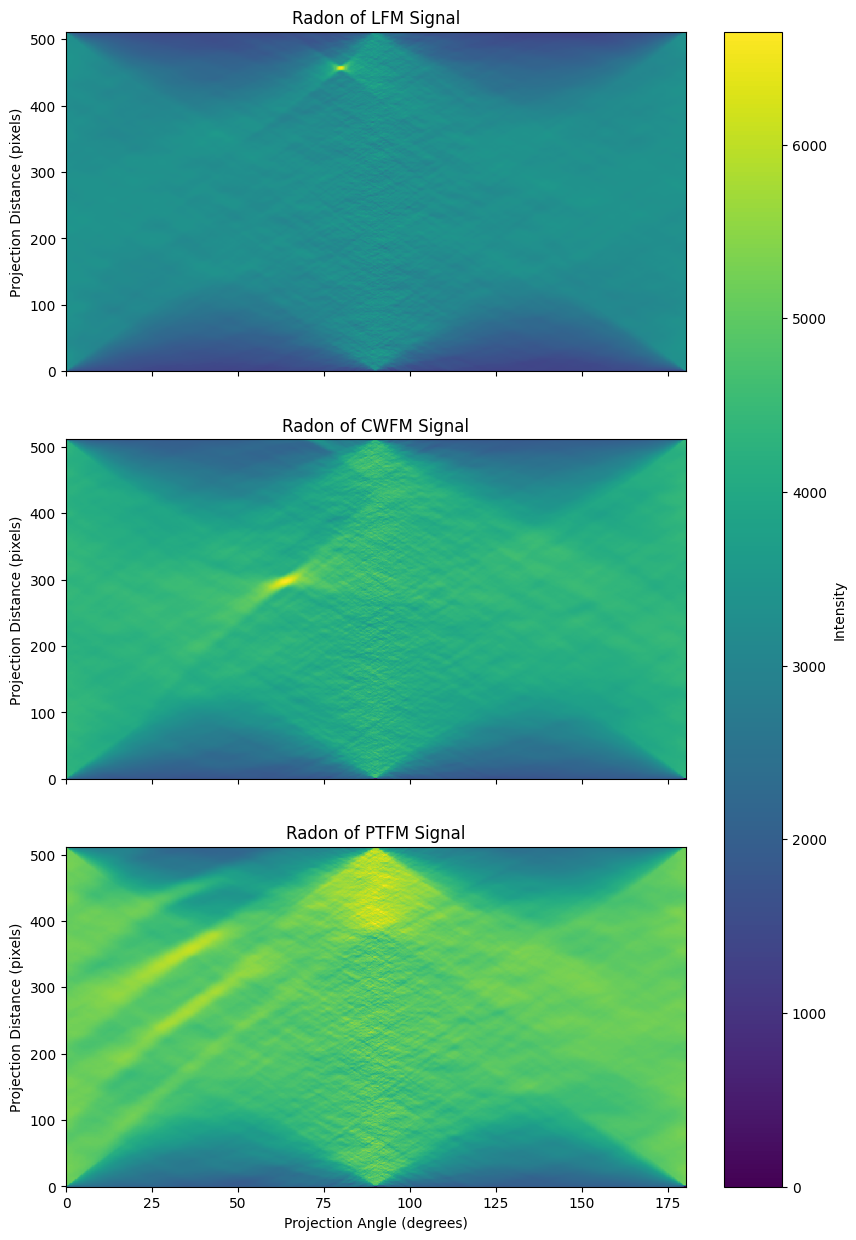

In [ ]:
theta_lfm , r_lfm = radon2(Sxx_lfm,Normal = True);
theta_ptfm, r_ptfm= radon2(Sxx_ptfm,Normal= True);
theta_cwfm, r_cwfm= radon2(Sxx_cwfm,Normal= True);

plt.figure(figsize=(5, 10))

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

axes[0].pcolormesh(theta_lfm, np.arange(r_lfm.shape[0]),r_lfm,shading='auto')
axes[0].set_title('Radon of LFM Signal')
axes[0].set_ylabel('Projection Distance (pixels)')

axes[1].pcolormesh(theta_cwfm, np.arange(r_cwfm.shape[0]) ,r_cwfm, shading='auto')
axes[1].set_title('Radon of CWFM Signal')
axes[1].set_ylabel('Projection Distance (pixels)')

im = axes[2].pcolormesh(theta_ptfm, np.arange(r_ptfm.shape[0]) , r_ptfm , shading='auto')
axes[2].set_title('Radon of PTFM Signal')
axes[2].set_xlabel('Projection Angle (degrees)')
axes[2].set_ylabel('Projection Distance (pixels)')

# Add colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.set_label("Intensity")

plt.show()


In [ ]:
def detect_signal(duration = 10, snr=0, type_of_signal = 0):
  print(type_of_signal)
  if type_of_signal==0:
    pulse,time = generate_lfm(duration , snr)
  elif type_of_signal==1:
    pulse,time = generate_cwfm(duration,snr);
  elif type_of_signal==2:
    pulse,time = generate_ptfm(duration,snr);
  print(len(pulse))
  t,f,stft_signal = stft(pulse[(len(pulse)-1)//2:]);
  theta , radon_image = radon2(stft_signal,Normal=True)
  flat_index = np.argmax(radon_image)
  coordinates = np.unravel_index(flat_index , radon_image.shape)
  print(coordinates)

  # so now i have my coordinates
  list_value = [radon_image[coordinates]];
  for i in range(1,10):
    t , f , stft_signal = stft(pulse[(len(pulse)-1)//2 - i*((L//2)) : len(pulse)-i*(L//2)]);
    theta,radon_image = radon2(stft_signal,Normal=True)
    list_value.append(radon_image[coordinates]);
  return list_value

signal_type = 2
list_value = detect_signal(duration=10,snr=0,type_of_signal=signal_type);




2
20001
1024 177


<ipython-input-6-ad3949994109>:15: DeprecationWarning: Importing chebwin from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.chebwin' or the convenience function 'scipy.signal.get_window' instead.
  window = chebwin(window_size, at=60)#at=60 means side lob attenuation


(432, 262)
1024 177
1024 177
1024 177
1024 177
1024 177
1024 177
1024 177
1024 177
1024 177


In [ ]:
print(list_value)

mean_value = np.mean(list_value)
deviation_value = np.std(list_value)
print(mean_value,deviation_value)
print(mean_value + VT*deviation_value)

signal_name = "LFM"
if signal_type == 1:
  signal_name = "CWFM"
elif signal_type == 2:
  signal_name = "PTFM"

The_threshold = mean_value + VT*deviation_value
if The_threshold >= list_value[0]:
  print(" Only Noise ")
else:
  print(f" Combination of Noise and {signal_name} Sonar WAVE")

[6713.3622381146515, 6155.43783801587, 5670.491725811609, 5831.417376993704, 6041.283625922646, 5653.211356285344, 5373.470095975878, 5173.817792051659, 5116.539560455166, 5334.673344467797]
5706.370495409433 472.02806245818977
6744.832232817451
 Only Noise 


In [ ]:
def testing_module():
  probability_ans = [];
  for i in range(3):
    probability = [];
    for snr in range (-40 , 41,5):
      print("Doing SNR : ",snr)
      if i==0:
        pulse ,time = generate_lfm(10,snr)
      elif i==1:
        pulse,time = generate_cwfm(10,snr)
      else:
        pulse,time = generate_ptfm(10,snr)
      print(f"Pulse : {len(pulse)}")
      answer = [];
      store_radon_images = [];
      for start in range (0, (len(pulse)+1)//2,L//2):
        sample_pulse = pulse[start:start+(len(pulse)+1)//2]
        t,f,stft_signal = stft(sample_pulse);
        theta , radon_image = radon2(stft_signal,Normal=True)
        store_radon_images.append(radon_image)
        print(f"Start : {start} for the snr : {snr}")

      for end in range(9,len(store_radon_images)):
        temp_radon = store_radon_images[end];
        flat_index = np.argmax(temp_radon)
        coordinates = np.unravel_index(flat_index , temp_radon.shape)

        temp_array = store_radon_images[end-9:end+1]
        print(f"Temp array : {len(temp_array)}")
        temp = []
        for t in temp_array:
          temp.append(t[coordinates[0]][coordinates[1]])
        temp_array = np.array(temp)
        Threshold = np.mean(temp_array) + VT*np.std(temp_array);
        answer.append(Threshold <= temp_array[len(temp_array)-1]);

      probability.append(sum(answer)/len(answer));

      print("Done with SNR : ",snr)
    probability_ans.append(probability)
  return probability_ans

test = testing_module();

Doing SNR :  -40
<class 'numpy.float64'> <class 'numpy.ndarray'>
Pulse : 20001
1024 177


<ipython-input-5-ad3949994109>:15: DeprecationWarning: Importing chebwin from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.chebwin' or the convenience function 'scipy.signal.get_window' instead.
  window = chebwin(window_size, at=60)#at=60 means side lob attenuation


Start : 0 for the snr : -40
1024 177
Start : 512 for the snr : -40
1024 177
Start : 1024 for the snr : -40
1024 177
Start : 1536 for the snr : -40
1024 177
Start : 2048 for the snr : -40
1024 177
Start : 2560 for the snr : -40
1024 177
Start : 3072 for the snr : -40
1024 177
Start : 3584 for the snr : -40
1024 177
Start : 4096 for the snr : -40
1024 177
Start : 4608 for the snr : -40
1024 177
Start : 5120 for the snr : -40
1024 177
Start : 5632 for the snr : -40
1024 177
Start : 6144 for the snr : -40
1024 177
Start : 6656 for the snr : -40
1024 177
Start : 7168 for the snr : -40
1024 177
Start : 7680 for the snr : -40
1024 177
Start : 8192 for the snr : -40
1024 177
Start : 8704 for the snr : -40
1024 177
Start : 9216 for the snr : -40
1024 177
Start : 9728 for the snr : -40
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Temp array : 10
Done with SNR :  -40
Doing SNR :  -35

making copies of the array

In [ ]:
test1=test
test2=test

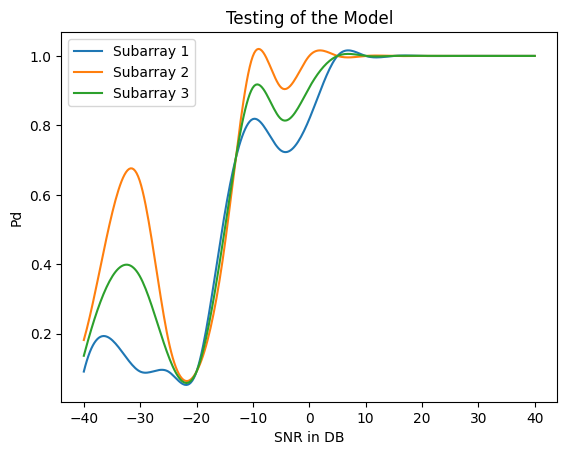

In [ ]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

# # Assuming test_array has dimensions (3, 17)
# test_array = np.random.rand(3, 17)  # Replace this with your actual data

snr_indb = np.arange(-40, 41, 5)
x_smooth = np.linspace(snr_indb.min(), snr_indb.max(), 300)

# Plot each subarray in test_array with different colors and labels
for i in range(3):
    spl = make_interp_spline(snr_indb, test1[i], k=3)
    y_smooth = spl(x_smooth)
    plt.plot(x_smooth, y_smooth, label=f'Subarray {i + 1}')

plt.xlabel('SNR in DB')
plt.ylabel('Pd')
plt.title('Testing of the Model')

# Add a legend
plt.legend()

# Show the plot
plt.show()


Final Graph obtained

In [1]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

# # Assuming test_array has dimensions (3, 17)
# test_array = np.random.rand(3, 17)  # Replace this with your actual data

snr_indb = np.arange(-40, 41, 5)
x_smooth = np.linspace(snr_indb.min(), snr_indb.max(), 300)

# Plot each subarray in test_array with different colors and labels
for i in range(3):
    spl = make_interp_spline(snr_indb, test1[i], k=3)
    y_smooth = spl(x_smooth)
    plt.plot(x_smooth, y_smooth, label=f'Subarray {i + 1}')

plt.xlabel('SNR in DB')
plt.ylabel('Pd')
plt.title('Testing of the Model')

# Add a legend
plt.legend()

# Show the plot
plt.show()


NameError: ignored

In [2]:
test

NameError: ignored